Plot the correlation between tags and transcriptome signal.
Annotation file is the covariets file from splotch

In [1]:
import os
import glob
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from scipy.stats import linregress, spearmanr, pearsonr
import numpy as np
import math
import seaborn as sns
%matplotlib inline
matplotlib.rcParams.update({'axes.linewidth': 0.25,
                            'xtick.major.size': 2,
                            'xtick.major.width': 0.25,
                            'ytick.major.size': 2,
                            'ytick.major.width': 0.25,
                            'pdf.fonttype': 42,
                            'font.sans-serif': 'Arial',
                           'ps.fonttype':42})

In [2]:
path = '../../smomics_data'


In [3]:
import warnings
warnings.filterwarnings('ignore')

# mRNA

In [4]:
# Read file
filename = os.path.join(path, 'lambdas_pmeans_spleen_exons_mRNA_6tags.tsv')
lambda_posterior_means = pd.read_csv(filename, index_col=0, sep='\t', header=[0,1])

In [5]:
# Change names on genes, ie remove '_'
nwe=[]
nm=lambda_posterior_means.index
for item in nm:
    nwe.append(str(item).split("_")[0])
lambda_posterior_means.index = nwe

# Take exp()
lambda_posterior_means = lambda_posterior_means.astype(float)
lambda_posterior_means = np.exp(lambda_posterior_means-1)


In [6]:
# Select gene
pd.set_option('display.max_colwidth', -1)
genes = ['Adgre1', 'Ighd', 'Cd8a', 'Cd4', 'Cd38', 'Cd163']

collect_genes = {}
for gene in genes:
    # subset all genes
    
    if not gene in lambda_posterior_means.index:
        continue
    
    lambda_gene = lambda_posterior_means.loc[gene, :].to_frame().reset_index()
    lambda_gene =  lambda_gene[(lambda_gene[gene] > np.percentile(lambda_gene[gene].values,0.5)) & (lambda_gene[gene] < np.percentile(lambda_gene[gene].values,99.5))]
    # Get name of file, for plotting
    lambda_gene['name'] = lambda_gene['file'].str.split('/').str[-1].str.split('_stdata').str[0]

    collect_genes[gene] = lambda_gene


# Ab

In [7]:
# Read file
filename = os.path.join(path, 'lambdas_pmeans_spleen_exons_tags_6tags.tsv')
lambda_posterior_meansTAGS = pd.read_csv(filename, index_col=0, sep='\t', header=[0,1])

# Take exp()
lambda_posterior_meansTAGS = lambda_posterior_meansTAGS.astype(float)
lambda_posterior_meansTAGS = np.exp(lambda_posterior_meansTAGS-1)


In [8]:
# Change names on genes, ie remove '_'
nwe=[]
nm=lambda_posterior_meansTAGS.index
for item in nm:
    nwe.append(str(item).split("-")[0])
lambda_posterior_meansTAGS.index = nwe

In [9]:
# Select gene
pd.set_option('display.max_colwidth', -1)
tags = lambda_posterior_meansTAGS.index

collect_tags = {}
for tag in tags:
    lambda_tag = lambda_posterior_meansTAGS.loc[tag, :].to_frame().reset_index()
    lambda_tag =  lambda_tag[(lambda_tag[tag] > np.percentile(lambda_tag[tag].values,0.1)) & (lambda_tag[tag] < np.percentile(lambda_tag[tag].values,100))]
    # Get name of file, for plotting

    # Get name of file, for plotting
    lambda_tag['name'] = lambda_tag['file'].str.split('/').str[-1].str.split('_stdata').str[0]

    collect_tags[tag] = lambda_tag

# Annotation

In [10]:
annot_list = []

for stdata in list(set(lambda_tag['name'].tolist())):
    
    well = stdata
       
    filename = os.path.join(path, well + '_stdata_adjusted.tsv.annotations.tsv')

    annot_file = pd.read_csv(filename, sep = '\t')
    annot_file = pd.melt(annot_file, id_vars='Unnamed: 0')
    annot_file = annot_file[annot_file['value'] != 0]
    annot_file['image'] = well
    annot_file.drop(['value'], axis=1, inplace=True)
    annot_file.rename(columns = {'Unnamed: 0':'value', 'variable':'x_y'}, inplace=True)
    annot_list.append(annot_file)
    
# Concat
annotdf = pd.concat(annot_list)

#clean up 
annotdf = annotdf[~annotdf['value'].isin(['White pulp'])]



In [11]:
annotdf['value'] = annotdf['value'].replace({'B follicle':'B follicle',
                         'PALS':'PALS',
                         'Marginal zone':'Marginal zone',})

In [12]:
annotdf.groupby('value').count()

,x_y,image
value,,
B follicle,554,554
Marginal zone,158,158
PALS,187,187
Red pulp,903,903


# Merge gene + ab + annotation

In [22]:
collect_merged = {}
for count, gene in enumerate(collect_genes):
    
    if gene == "Adgre1":
        tag = "F480"
    if gene == "Ighd":
        tag = "IgD"
    if gene == "Cd8a":
        tag = "CD8a"
    if gene == "Cd4":
        tag = "CD4"
    if gene == "Cd38":
        tag = "CD38"
    if gene == "Cd163":
        tag = "CD163"   
        
    lambda_gene = collect_genes[gene]
    
    if not tag in lambda_posterior_meansTAGS.index:
        continue
    
    lambda_tag = collect_tags[tag]
              
    # clean up naming
    lambda_gene = lambda_gene.drop("file", axis = 1)
    lambda_tag = lambda_tag.drop("file", axis = 1)
    lambda_gene.index = [i+"_"+j for i,j in zip(lambda_gene['name'], lambda_gene['coordinate'])]
    lambda_tag.index = [i+"_"+j for i,j in zip(lambda_tag['name'], lambda_tag['coordinate'])]
    annotdf.index = [i+"_"+j for i,j in zip(annotdf['image'], annotdf['x_y'])]
    
    #merge dfs
    lambdadfTMP = pd.merge(lambda_gene, lambda_tag,  left_index = True, right_index = True)
    lambdadf = pd.merge(lambdadfTMP, annotdf, how='left', left_index = True, right_index = True)
    
    # select annotation area
    lambdadf_rm = lambdadf[lambdadf['value'].isin(['Red pulp','Marginal zone', 'B follicle', 'PALS', 'White pulp'])]
    
    # check if anything needs removing
    # Remove sample (only want 3 samples)
    sample_to_rm = ['10015CN87_D1',]
    lambdadf_rm = lambdadf_rm[~lambdadf_rm['name_x'].isin(sample_to_rm)]
    
    #get averages per annotation regions
    trans = lambdadf_rm.groupby(['name_x', 'value'])[tag, gene].mean()
    trans.reset_index(inplace=True)
    
    # Scale min max per sample
    trans[[tag + '.norm', gene + '.norm']] = trans.groupby(['name_x'])[tag, gene].transform(lambda x: preprocessing.minmax_scale(x))#preprocessing.minmax_scale(x))
    collect_merged[gene] = trans


Adgre1
std err:0.306
Spearman's rho: 0.66
p-value: 0.018461400604744424
Ighd
std err:0.238
Spearman's rho: 0.61
p-value: 0.03586562977094836
Cd8a
std err:0.191
Spearman's rho: 0.59
p-value: 0.04537616490610366
Cd4
std err:0.193
Spearman's rho: 0.59
p-value: 0.044900704059893236
Cd38
std err:0.294
Spearman's rho: 0.66
p-value: 0.019041948187569345
Cd163
std err:0.308
Spearman's rho: -0.41
p-value: 0.18057712450958976


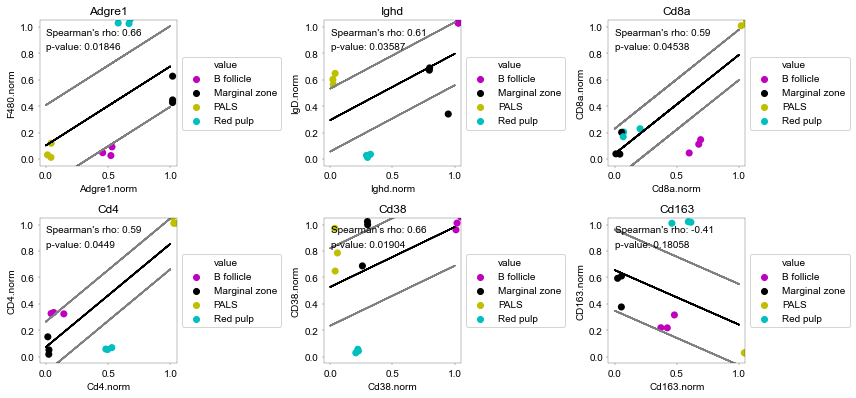

In [23]:
# initialize a figure
fig = matplotlib.pyplot.figure(figsize=(12, 8))
num_cols = 3
axes = []

for i in range(0,int((int(len(genes)+2)/num_cols))):
    for j in range(0, num_cols):
        ax = plt.subplot2grid((int((len(genes)+2)/num_cols+1), num_cols), (i, j))
        axes.append(ax) 
for count, gene in enumerate(collect_merged):

    ax = axes[count]
    plot_trans = collect_merged[gene]
    
    if gene == "Adgre1":
        tag = "F480"
    if gene == "Ighd":
        tag = "IgD"
    if gene == "Cd8a":
        tag = "CD8a"
    if gene == "Cd4":
        tag = "CD4"
    if gene == "Cd38":
        tag = "CD38"
    if gene == "Cd163":
        tag = "CD163"
    
    if not tag + '.norm' in plot_trans.columns:
        continue

    plot_trans['jitter_y'] = plot_trans[tag + '.norm'] + 0.05 * np.random.rand(len(plot_trans[tag + '.norm'].tolist())) +0.01
    plot_trans['jitter_x'] = plot_trans[gene + '.norm'] + 0.05 * np.random.rand(len(plot_trans[gene + '.norm'].tolist())) +0.01
    x = 'jitter_x'
    y = 'jitter_y'
    hue = 'value'
    palette = {'Red pulp':'c', 'B follicle':'m', 'PALS':'y', 'Marginal zone':'k', 'White pulp':'r', 'IGDpos':'b'}
    data = plot_trans

    sns.scatterplot(x=x, y=y, data=data, ax=ax, hue=hue, s=50, linewidth=0, palette=palette)

    # X and Y axis
    ax.set_xlabel(gene + '.norm')
    ax.set_ylabel(tag + '.norm')

    # Calculate the linear regression
    X = gene + '.norm'
    Y = tag + '.norm'

    slope, intercept, r_value, p_value, std_err = linregress(data[X], data[Y])

    print(gene)
    print('std err:' + str(round(std_err, 3)))

    coef = np.polyfit(data[X],data[y],1)
    poly1d_fn = np.poly1d(coef)
    ax.plot(data[X], poly1d_fn(data[X]), c="k")
    ax.plot(data[X], poly1d_fn(data[X])+std_err, c="grey")
    ax.plot(data[X], poly1d_fn(data[X])-std_err, c="grey")
    #ax.errorbar(trans[x], poly1d_fn(trans[x]), yerr=poly1d_fn(trans[x]) - trans[y], fmt='.k')

    # Spearman's & Pearson's r
    spear, ps = spearmanr(data[X], data[Y])
    pear, pp = pearsonr(data[X], data[Y])
    print("Spearman's rho: " + str(round(spear, 2)))
    print("p-value: " + str(ps))

    ax.text(0.05, 0.9, "Spearman's rho: " + str(round(spear, 2)), transform=ax.transAxes, fontsize=10)
    ax.text(0.05, 0.8, "p-value: " + str(round(ps, 5)), transform=ax.transAxes, fontsize=10)
    #ax.get_legend().remove()

    # title
    ax.set_title(gene)

    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()

plt.savefig("../../figures/sm_mrna_vs_tags.pdf", transparent=True, bbox_inches = 'tight',
   pad_inches = 0, dpi=1200, rasterized=True)